# Time Series in Anomaly Detection

## Exercise

### Imports

In [3]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import env as e
import seaborn as sns
%matplotlib inline

# pd.plotting.register_matplotlib_converters()

### Acquire

In [10]:
query = '''SELECT * FROM logs'''

df = e.get_data('NA', query, 'logs.csv')

Used cached CSV.
Rows and Columns: (900223, 6)


### Prepare

In [12]:
df

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [13]:
# Rename columns ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']

df.columns = ['date', 'time', 'endpoint', 'user_id', 'cohort_id', 'source_ip']

In [14]:
# convert date column to datetime format
df.date = pd.to_datetime(df.date)

# set the date column as the index
df = df.set_index(df.date)

# resample the data by day and count the number of pages accessed each day
pages = df['endpoint'].resample('d').count()

# display the first 5 rows of the resulting dataframe
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

#### EMA

In [16]:
# compute 7 day EMA
ema_7d = pages.ewm(span=7).mean()

In [15]:
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()

In [17]:
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()

In [18]:
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()

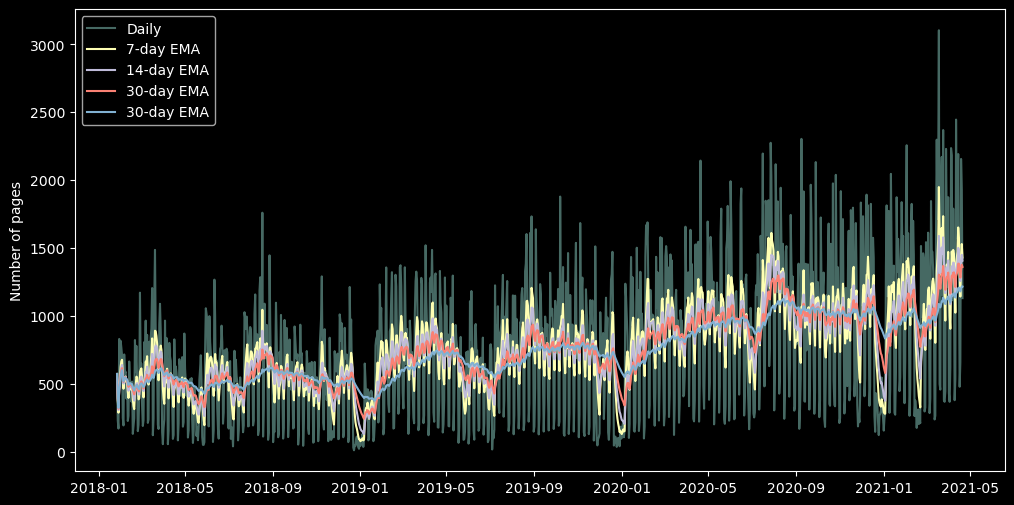

In [20]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(12,6))

# plot the daily page count with alpha of 0.5
ax.plot(pages.index, pages, label='Daily', alpha=.5)

# plot the 7-day EMA
ax.plot(pages.index, ema_7d, label = '7-day EMA')

# plot the 14-day EMA
ax.plot(pages.index, ema_14d, label = '14-day EMA')

# plot the 30-day EMA
ax.plot(pages.index, ema_30d, label = '30-day EMA')

# plot the 90-day EMA
ax.plot(pages.index, ema_90d, label = '30-day EMA')

# add a legend to the plot
ax.legend(loc='best')

# set the y-axis label
ax.set_ylabel('Number of pages')

# show the plot
plt.show()

Bollinger Bands

- a volatility indicator and commonly used in stock market trading.

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.

Midband

- The Exponential Moving Average

midband = train.ewm(span=30).mean()

Upper & Lower Band

- UB/LB = Midband +/- stdev * K

- stdev = train.ewm(span=30).std()

- K = the number of standard deviations to go up and down from the EMA

%b, Percent Bandwidth

- Shows where the last value sits in relation to the bands

- %b = (last−LB) / (UB−LB)

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband.

Bandwidth

- The width of the bands 

- (UB - LB) / Midband

In [21]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [22]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [23]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub

date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
                 ...     
2021-04-17    3545.216722
2021-04-18    3486.733695
2021-04-19    3569.147958
2021-04-20    3579.231798
2021-04-21    3499.094360
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [24]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835
2018-01-29,1406.405897,-492.401124
2018-01-30,1354.808245,-352.070116


In [25]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


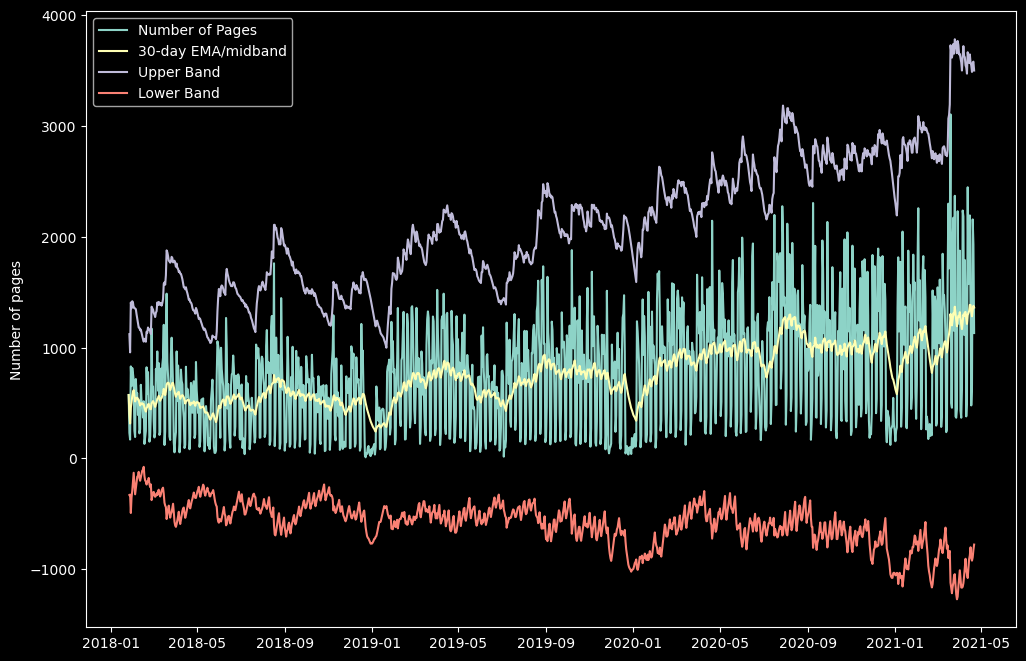

In [26]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(12,8))

# plot the daily page count
ax.plot(my_df.index, my_df.pages, label='Number of Pages')

# plot the 30-day EMA/midband
ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')

# plot the upper band
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')

# plot the lower band
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

# add a legend to the plot
ax.legend(loc='best')

# set the y-axis label
ax.set_ylabel('Number of pages')

# show the plot
plt.show()

In [27]:
# get the last measure of gb
last_measure = my_df.iloc[-1].pages
last_measure

1131.0

In [29]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub

3499.0943598250406

In [31]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb

-777.3404511353885

In [32]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.45


In [33]:
my_df.tail(3)

,pages,midband,ub,lb
date,,,,
2021-04-19,2156,1338.574023,3569.147958,-891.999913
2021-04-20,1930,1376.730537,3579.231798,-825.770723
2021-04-21,1131,1360.876954,3499.094360,-777.340451


In [34]:
# compute %b by subtracting the lower band from the number of pages and dividing by the difference between the upper and lower bands
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

# display the first 5 rows of the resulting dataframe
my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


In [36]:
# This code filters the rows of my_df where the value of pct_b is greater than 1, indicating an anomaly.
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,


In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def acquire(file_name, column_names):
    '''
    Reads a CSV file with given column names.
    
    Parameters:
    - file_name (str): Name of the file to be read.
    - column_names (list): List of column names for the DataFrame.
    
    Returns:
    - DataFrame: A DataFrame with the desired columns from the CSV file.
    '''
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    '''
    Prepares the DataFrame by filtering for a specific user and setting the date as an index.
    
    Parameters:
    - df (DataFrame): The initial DataFrame.
    - user (int/str): The user_id to filter by.
    
    Returns:
    - Series: A Series with dates as the index and the count of pages as values.
    '''
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    '''
    Computes the Bollinger Bands and Percentage B for the given data.
    
    Parameters:
    - pages (Series): A series with the count of pages.
    - span (int): The span for the Exponential Moving Average (EMA).
    - weight (float): The weight for calculating the bands.
    - user (int/str): The user_id.
    
    Returns:
    - DataFrame: A DataFrame with calculated Bollinger Bands and Percentage B values.
    '''
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    '''
    Plots the Bollinger Bands for a user's data.
    
    Parameters:
    - my_df (DataFrame): The DataFrame containing Bollinger Bands data.
    - user (int/str): The user_id.
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    '''
    Finds anomalies in the user's data using Bollinger Bands.
    
    Parameters:
    - df (DataFrame): The initial DataFrame.
    - user (int/str): The user_id to filter and check for anomalies.
    - span (int): The span for the Exponential Moving Average (EMA).
    - weight (float): The weight for calculating the bands.
    
    Returns:
    - DataFrame: A DataFrame containing the anomalies.
    '''
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    return my_df[my_df.pct_b>1]


In [39]:
# set the span and weight for the Bollinger Bands
span = 30
weight = 3.5

# create an empty DataFrame to store anomalies
anomalies = pd.DataFrame()

# loop through each unique user_id in the DataFrame
for u in list(df.user_id.unique()):
    
    # find anomalies for the current user using the find_anomalies function
    user_df = find_anomalies(df, u, span, weight)
    
    # concatenate the user_df with the anomalies DataFrame
    anomalies = pd.concat([anomalies, user_df], axis=0)

## Notes

### Things I missed due to stepping out.

Look into

- bollanger band